# <center>Terry Stops Classifier

## Business Understanding
**Stakeholder**: Seattle Police Department (SPD)  
**Business Problem**: The SPD wants to identify which factors contribute to an arrest during Terry Stops to reduce unnecessary stops and enhance resource allocation.  
**Objective**: Build a classification model to predict whether a stop leads to an arrest.  
**Target Variable**: Arrest Flag (1 = Arrested, 0 = Not Arrested)  
**Value**: Insights can help SPD prioritize high-risk stops while reducing bias and inefficiency in policing.

# Data Understanding

In [1]:
#Import the necessary libraries/packages for EDA, modeling, and evaluation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, FunctionTransformer
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.linear_model import LinearRegression, LassoCV, LogisticRegression
from sklearn.feature_selection import RFECV, RFE 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier

In [6]:
#load dataset
df = pd.read_csv("Terry_Stops_20250719.csv")
df.head() #data preview

,Subject Age Group,Subject ID,GO / SC Num,Terry Stop ID,Stop Resolution,Weapon Type,Officer ID,Officer YOB,Officer Gender,Officer Race,...,Reported Time,Initial Call Type,Final Call Type,Call Type,Officer Squad,Arrest Flag,Frisk Flag,Precinct,Sector,Beat
0,46 - 55,-1,2.020000e+13,481899,Field Contact,NaN,8544,1993,Female,Hispanic,...,47:00.0,-,-,-,NORTH PCT 2ND WATCH - B/N RELIEF,N,N,West,Q,Q2
1,18 - 25,-1,2.020000e+13,445585,Offense Report,NaN,8588,1986,Female,White,...,43:00.0,"OBS WEAPN-IP/JO-GUN,DEADLY WPN (NO THRT/ASLT/D...","WEAPON, PERSON WITH - GUN",911,TRAINING - FIELD TRAINING SQUAD,N,Y,North,J,J1
2,26 - 35,-1,2.020000e+13,234548,Offense Report,NaN,4852,1953,Male,Asian,...,36:00.0,DISTURBANCE,THEFT - SHOPLIFT,911,NORTH PCT 2ND W - LINCOLN - PLATOON 1,N,N,North,L,L3
3,36 - 45,49326761681,2.020000e+13,49327076666,Field Contact,Knife/Cutting/Stabbing Instrument,7766,1984,Male,White,...,25:58.0,OBS - DOWN - CHECK FOR PERSON DOWN,SUSPICIOUS CIRCUM. - SUSPICIOUS PERSON,ONVIEW,WEST PCT 1ST W - QUEEN (DAVID) - PLATOON 1,N,Y,West,K,K3
4,Jan-17,48319519002,2.020000e+13,48319446887,Field Contact,-,8765,1992,Male,Two or More Races,...,53:15.0,MVC - HIT AND RUN,TRAFFIC - MV COLLISION INVESTIGATION,911,SOUTH PCT 3RD W - ROBERT (OCEAN) - PLATOON 1,N,N,South,R,R2


In [7]:
#Exploratory data analysis
df.info()
df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64186 entries, 0 to 64185
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Subject Age Group         64186 non-null  object 
 1   Subject ID                64186 non-null  int64  
 2   GO / SC Num               64186 non-null  float64
 3   Terry Stop ID             64186 non-null  int64  
 4   Stop Resolution           64186 non-null  object 
 5   Weapon Type               31621 non-null  object 
 6   Officer ID                64186 non-null  object 
 7   Officer YOB               64186 non-null  int64  
 8   Officer Gender            64186 non-null  object 
 9   Officer Race              64186 non-null  object 
 10  Subject Perceived Race    64186 non-null  object 
 11  Subject Perceived Gender  64186 non-null  object 
 12  Reported Date             64186 non-null  object 
 13  Reported Time             64186 non-null  object 
 14  Initia

Subject Age Group               0
Subject ID                      0
GO / SC Num                     0
Terry Stop ID                   0
Stop Resolution                 0
Weapon Type                 32565
Officer ID                      0
Officer YOB                     0
Officer Gender                  0
Officer Race                    0
Subject Perceived Race          0
Subject Perceived Gender        0
Reported Date                   0
Reported Time                   0
Initial Call Type               0
Final Call Type                 0
Call Type                       0
Officer Squad                 563
Arrest Flag                     0
Frisk Flag                      0
Precinct                        0
Sector                          0
Beat                            0
dtype: int64

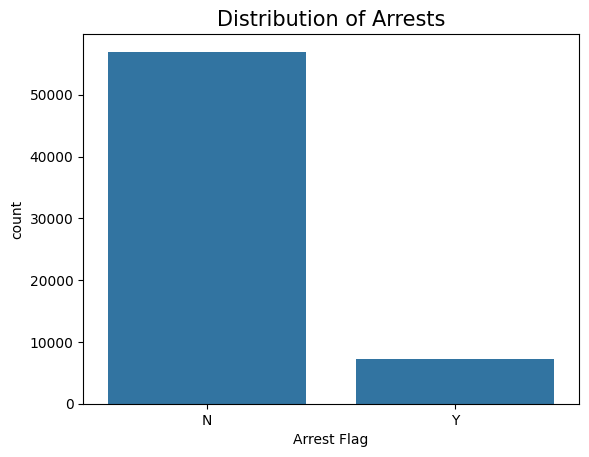

In [8]:
#Target Distribution Visualization
sns.countplot(x='Arrest Flag', data=df)
plt.title('Distribution of Arrests', fontsize = 15)
plt.show()

- There appears to be a massive class imbalance in the target variable. 
- Must keep this in mind for modeling stages and adjusted accordingly.
- The trained model might end up predicting non-arrests better than arrests.

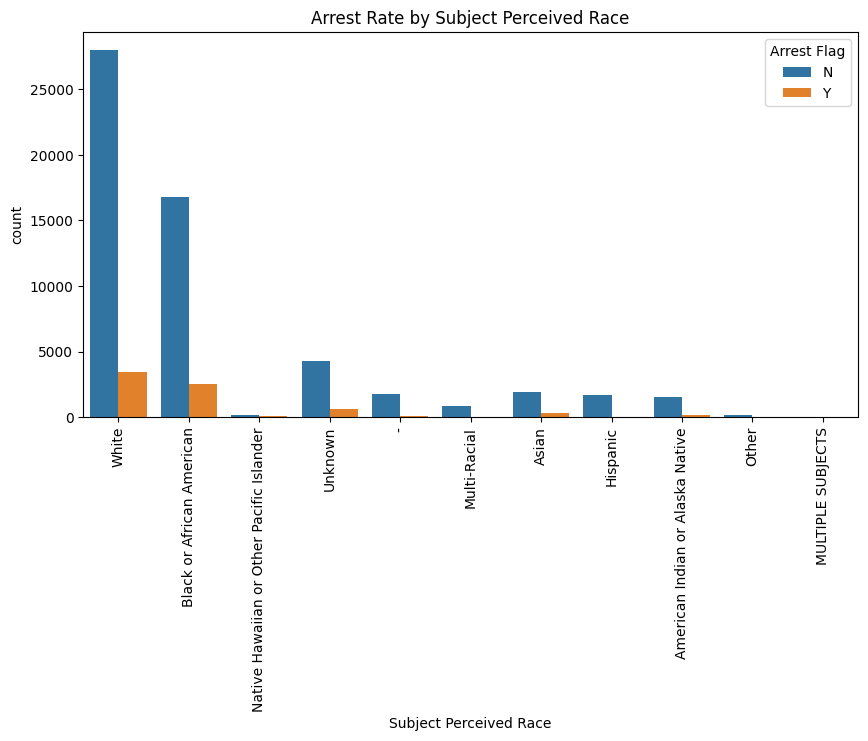

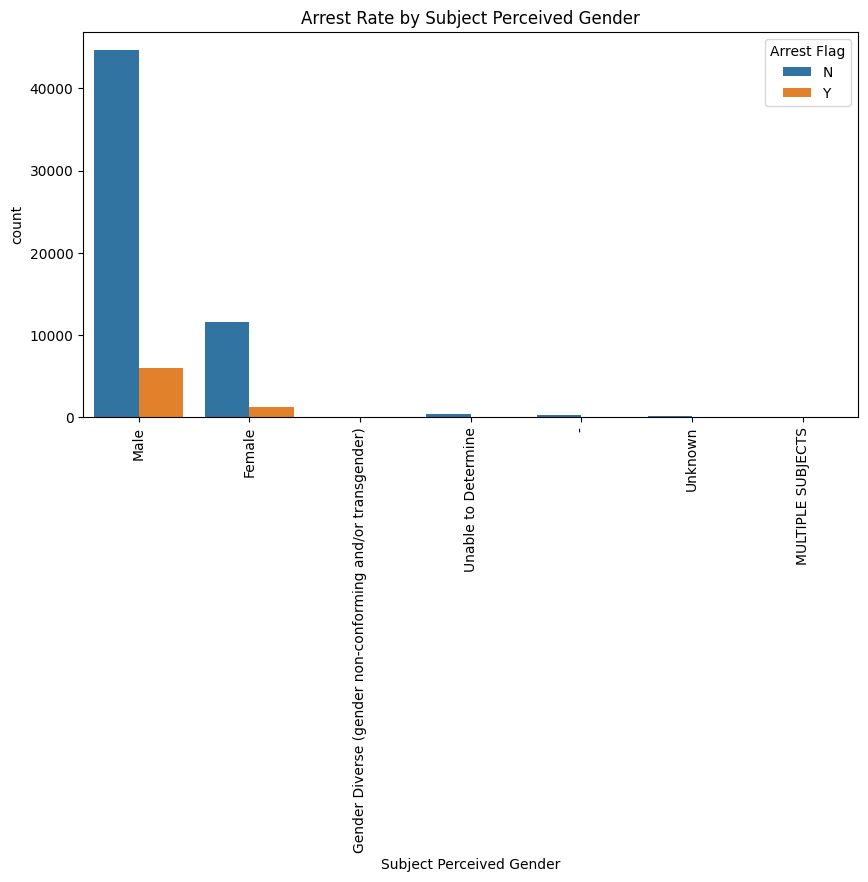

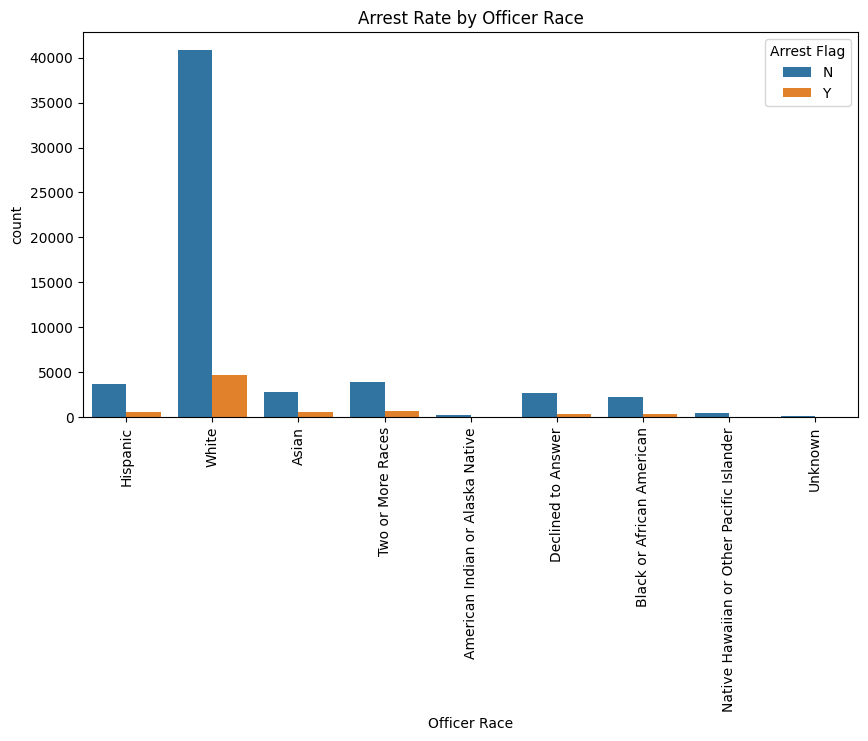

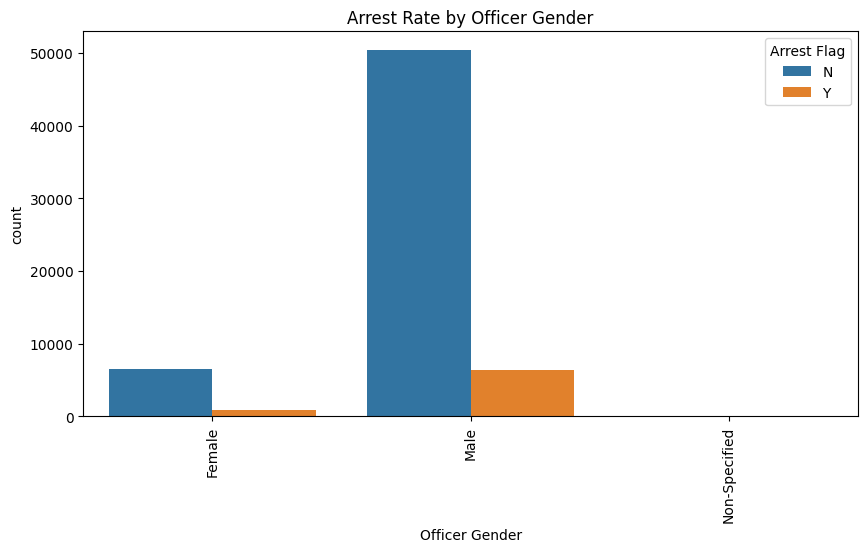

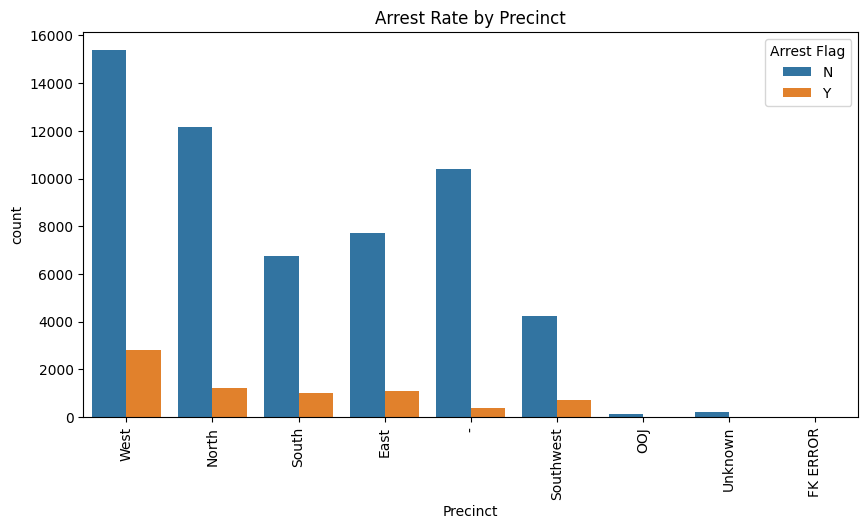

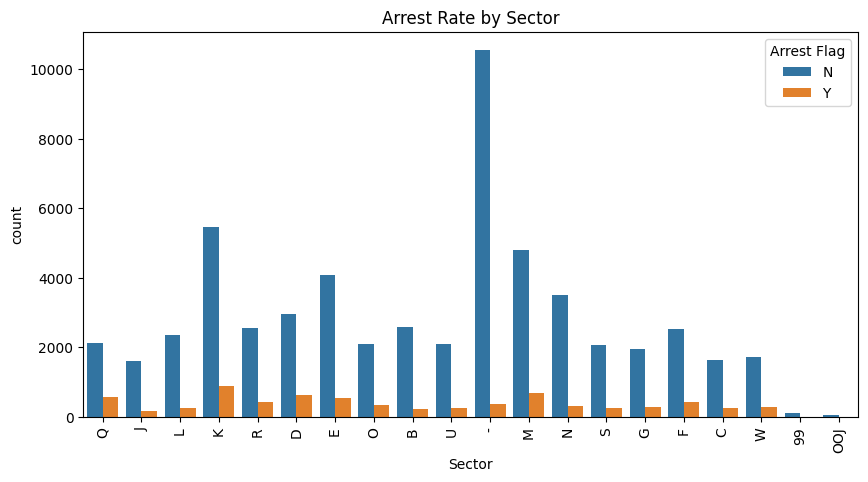

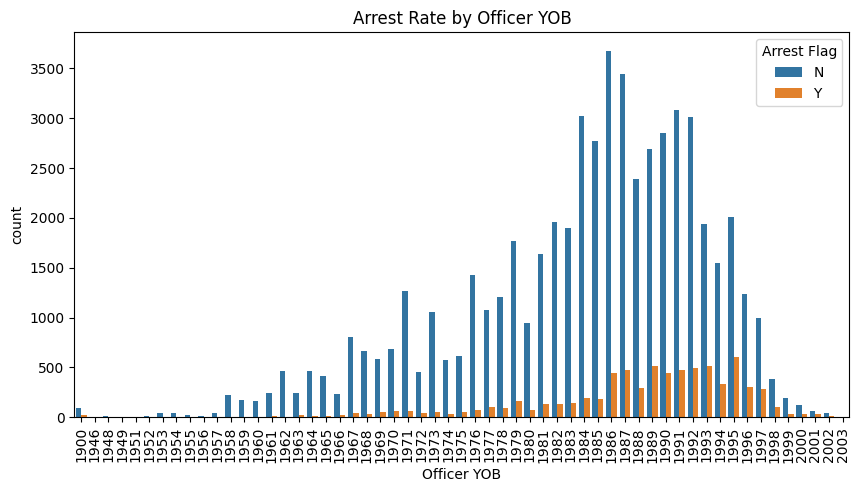

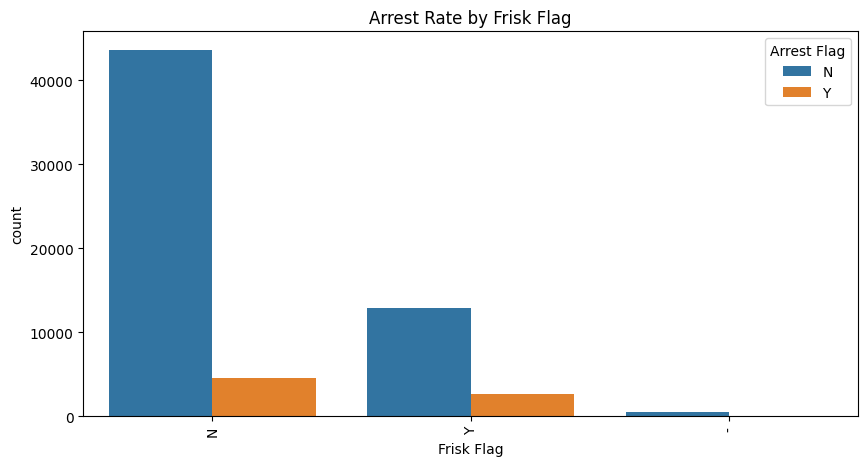

In [9]:
#Relationship Between Target Variable and Selected Categorical Variables
categorical_cols = ['Subject Perceived Race', 'Subject Perceived Gender', 'Officer Race', 'Officer Gender', 'Precinct', 
                    'Sector', 'Officer YOB', 'Frisk Flag']
for col in categorical_cols:
    plt.figure(figsize=(10,5))
    sns.countplot(x=col, hue='Arrest Flag', data=df)
    plt.title(f'Arrest Rate by {col}')
    plt.xticks(rotation=90)
    plt.show()

             Officer Age  Arrest Flag  Frisk Flag
Officer Age     1.000000    -0.131963   -0.039828
Arrest Flag    -0.131963     1.000000    0.107790
Frisk Flag     -0.039828     0.107790    1.000000


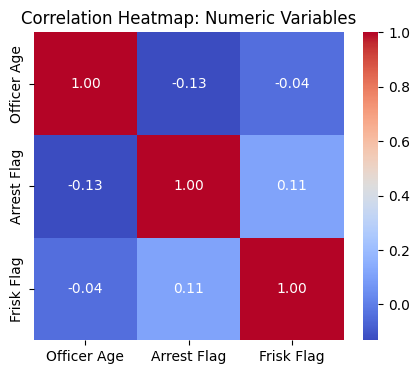

In [10]:
#Copy dataframe and prepare numeric columns
df_num = df.copy()

#Convert Arrest Flag and Frisk Flag to numeric
df_num['Arrest Flag'] = df_num['Arrest Flag'].map({'Y': 1, 'N': 0})
df_num['Frisk Flag'] = df_num['Frisk Flag'].map({'Y': 1, 'N': 0})

#Convert Officer YOB to age
df_num['Officer Age'] = 2025 - df_num['Officer YOB']

#Select final numeric columns
num_cols = ['Officer Age', 'Arrest Flag', 'Frisk Flag']
df_corr = df_num[num_cols].corr()
print(df_corr)

#Plot heatmap
plt.figure(figsize=(5, 4))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Numeric Variables")
plt.show()


## Data Preparation
Possible steps:
- Encode categorical variables (e.g., one-hot encoding or label encoding)

- Impute missing values (if needed, use SimpleImputer and fit only on training data)

- Split data into train and test sets before transformation to prevent leakage

- Scale numeric features (if using regularized logistic regression or distance-based models)

- Feature engineering (e.g., combining location info, time of day categories, etc.)

In [11]:
#check percentage of weapon type thats missing
missing_percent = df['Weapon Type'].isnull().mean() * 100
print(f"Missing: {missing_percent:.2f}%")

missing_percent2 = df['Officer Squad'].isnull().mean() * 100
print(f"Missing: {missing_percent2:.2f}%")

Missing: 50.74%
Missing: 0.88%


- Weapon Type is missing a lot of values and might be relevant to model-building.
- Check its importance before building a model and assess whether imputation or dropping it completely is the right move

In [12]:
#Engineer a new column to show weapon types that are missing
df['Weapon Type Missing'] = df['Weapon Type'].isnull().astype(int)

#Scoring Using Missingness Indicator (1 = missing, 0 = weapon type present)
model_missing_only = RandomForestClassifier(random_state=42)
score_missing_only = cross_val_score(
    model_missing_only,
    df[['Weapon Type Missing']],
    df['Arrest Flag'],
    cv=5).mean()

print(f"Score using only missingness indicator: {score_missing_only:.4f}")

# Scoring Using Actual Weapon Type Values 
df_notnull = df.dropna(subset=['Weapon Type'])

    # One-hot encode Weapon Type
X_weapon_encoded = pd.get_dummies(df_notnull[['Weapon Type']], drop_first=True)
y_notnull = df_notnull['Arrest Flag']

model_encoded = RandomForestClassifier(random_state=42)
score_encoded = cross_val_score(model_encoded, X_weapon_encoded, y_notnull, cv=5).mean()

print(f"Score using actual Weapon Type values (non-missing): {score_encoded:.4f}")


#Scoring After Imputing and Encoding Weapon Type
df['Weapon_Type_filled'] = df['Weapon Type'].fillna('Unknown')
X_full_encoded = pd.get_dummies(df[['Weapon_Type_filled']], drop_first=True)

model_imputed = RandomForestClassifier(random_state=42)
score_imputed = cross_val_score(model_imputed, X_full_encoded, df['Arrest Flag'], cv=5).mean()

print(f"Score after imputing and encoding Weapon Type: {score_imputed:.4f}")


Score using only missingness indicator: 0.8874
Score using actual Weapon Type values (non-missing): 0.7712
Score after imputing and encoding Weapon Type: 0.8870


### Model Comparison Results
| Model Version                                  | CV Score   | Interpretation                                                            |
| ---------------------------------------------- | ---------- | ------------------------------------------------------------------------- |
|  **Missingness indicator only**               | **0.8874** | Highest score      |
|  **Actual Weapon Type values** (no missing) | 0.7712     | Much lower — actual values are *less predictive* than missingness itself. |
|  **Imputed + Encoded Weapon Type**            | 0.8870     | Almost same as missingness only — imputation doesn't add useful signal.   |  

- Missingness is better than Actual Data:

    - The fact that Weapon Type is missing tells the model more about arrest likelihood than the actual weapon type does.

    - Possibly: unreported weapon types are correlated with non-arrests.

- Imputing Doesn’t Improve the Model

- Best Option for Modeling:

    - Keep the missingness indicator as a feature "Weapon_Type_missing" and drop the "Weapon Type" column


In [15]:
#Drop weapon type filled
df.drop(columns = ['Weapon_Type_filled'], inplace= True)

In [16]:
#Ensure target is numeric
df['Arrest Flag'] = df['Arrest Flag'].map({'Y': 1, 'N': 0})

#Map Frisk Flag as well
df['Frisk Flag'] = df['Frisk Flag'].map({'Y': 1, 'N': 0, '-': np.nan})  


In [17]:
#Ordinal encode subject age group
age_group_order = {
    'Jan-17': 0,
    '18 - 25': 1,
    '26 - 35': 2,
    '36 - 45': 3,
    '46 - 55': 4,
    '56 and Above': 5,
    '-': -1  # or np.nan
}
df['Subject Age Group'] = df['Subject Age Group'].map(age_group_order)


In [18]:
#check for missing values in Officer Age column
print(df['Officer YOB'].isnull().sum())  

0


In [19]:
#Engineer new Officer Age column
df['Officer Age'] = 2025 - df['Officer YOB']

In [20]:
#converting reported date to datetime and extracting features
df["Reported Date"] = pd.to_datetime(df["Reported Date"])  # Convert to datetime

#Extracting:
df["Reported Year"] = df["Reported Date"].dt.year
df["Reported Month"] = df["Reported Date"].dt.month
df["Reported Weekday"] = df["Reported Date"].dt.dayofweek  # 0=Monday, 6=Sunday
df["Reported Day"] = df["Reported Date"].dt.day

"""
These new columns will help in:
1. Detecting seasonal patterns
2. Analyzing weekend vs weekday trends
3. Using year to see trends over time 
"""

#Drop Reported Date column
df.drop(columns=['Reported Date'], inplace=True)

### Train Test Split
- Conducted here to prevent data leakage.

In [21]:
#Define features to use
predictors = ['Subject Age Group', 'Subject Perceived Race', 'Subject Perceived Gender',
    'Initial Call Type', 'Final Call Type', 'Frisk Flag',
    'Precinct', 'Sector', 'Officer Age', 'Officer Race',
    'Officer Gender','Weapon Type Missing', 'Reported Year', 'Reported Month', 'Reported Weekday',
    'Reported Day']

#Train_Test Split
X = df[predictors]
y = df['Arrest Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
#Stratify = preserves cass distribution in train_test split

#Confirm split and class balance
print("Train class balance:\n", y_train.value_counts(normalize=True))
print("Test class balance:\n", y_test.value_counts(normalize=True))


Train class balance:
 Arrest Flag
0    0.887357
1    0.112643
Name: proportion, dtype: float64
Test class balance:
 Arrest Flag
0    0.887366
1    0.112634
Name: proportion, dtype: float64


Target variable is highly imbalanced:

- Only 11.3% of cases lead to an arrest.

- About 88.7% do not lead to an arrest.

Can bias modeling to favor the majority class (no arrest), leading to:

- High accuracy but low recall for arrests.

- Poor performance on minority class.

In [22]:
#check data types in training data
X_train.dtypes

Subject Age Group             int64
Subject Perceived Race       object
Subject Perceived Gender     object
Initial Call Type            object
Final Call Type              object
Frisk Flag                  float64
Precinct                     object
Sector                       object
Officer Age                   int64
Officer Race                 object
Officer Gender               object
Weapon Type Missing           int64
Reported Year                 int32
Reported Month                int32
Reported Weekday              int32
Reported Day                  int32
dtype: object

### Encode categorical variables and Numeric Variables

Done because most scalers (like StandardScaler) work only on numeric data.

- Must encode categorical features (e.g., one-hot or ordinal) before scaling any numeric features.

- Otherwise, StandardScaler() will throw an error on string/object types.

In [30]:
#Separating columns based on datatype

#Numerical features to scale and possibly impute
numeric_features = ['Officer Age', 'Reported Year', 'Reported Month', 'Reported Weekday', 'Reported Day']

#Binary features with NaNs (impute if needed)
binary_features = ['Frisk Flag','Weapon Type Missing']

#Ordinal feature(already encoded): Subject Age Group
ordinal_features = ['Subject Age Group']

#Categorical features to one-hot encode
categorical_features = [
    'Subject Perceived Race',
    'Subject Perceived Gender',
    'Initial Call Type',
    'Final Call Type',
    'Precinct',
    'Sector',
    'Officer Race',
    'Officer Gender' 
]


In [31]:
#Constructing Pipelines
numeric_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

binary_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
    # no scaler needed for binary
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine into one transformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_pipeline, numeric_features),
    ('bin', binary_pipeline, binary_features),
    ('cat', categorical_pipeline, categorical_features),
    ('ord', 'passthrough', ordinal_features)
])


In [32]:
#checking for missing values in training set
missing_summary = X_train.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("Missing values in training data:\n", missing_summary)


Missing values in training data:
 Frisk Flag    384
dtype: int64


## Modeling

### 1. a) Baseline Model: Logistic Regression; A simple interpretable model

In [33]:
#Fitting a logistic regression model
model = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

model.fit(X_train, y_train)
preds = model.predict(X_test)


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.96      0.95     11392
           1       0.61      0.45      0.52      1446

    accuracy                           0.91     12838
   macro avg       0.77      0.71      0.73     12838
weighted avg       0.90      0.91      0.90     12838

Confusion Matrix:
 [[10973   419]
 [  795   651]]
ROC AUC Score: 0.9363


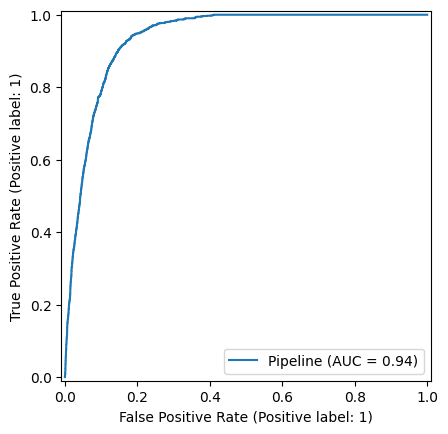

In [35]:
# Predict on test data
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # Probabilities for ROC AUC

# Classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_score:.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)


**Model 1 Evaluation Summary:**
- Overall Accuracy: 91%
- Good, but it is dominated by the majority class (0 = No Arrest)

For 1(Arrests):
- Low recall: The model is missing many actual arrests.

- Moderate precision: When it predicts an arrest, it’s correct about 61% of the time.

- F1-score is low, indicating imbalance and room for improvement.

ROC AUC Score: 0.9363

- Excellent separation ability overall, but it can still underperform for the minority class.

### b) Logistic Regression Addressing Class Imbalance

In [36]:
# Define the full modeling pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42))
])

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9537 1855]
 [ 117 1329]]
ROC AUC Score: 0.9357


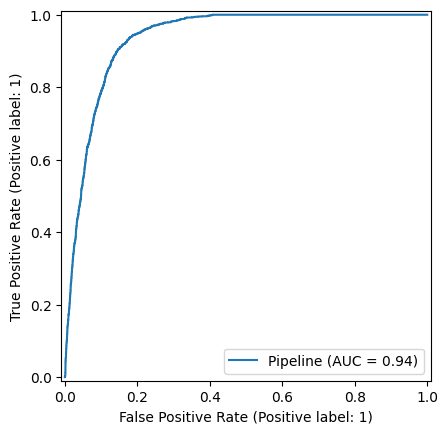

In [37]:
#Fit the pipeline
model_pipeline.fit(X_train, y_train)

#Prediction and Evaluation
# Predictions
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")

# ROC Curve
RocCurveDisplay.from_estimator(model_pipeline, X_test, y_test)


**Interpretation**  

What Improved

- Recall for Arrests (Class 1): jumped from 0.45 → 0.92, meaning its now catching almost all actual arrests.

- F1-Score for Class 1: improved, indicating better balance between precision and recall.

- True Positives (TP): went from 651 → 1329 (out of 1446)

What Decreased

- Precision for Class 1: dropped from 0.61 → 0.42 — the model is flagging more arrests, but some are false positives.

- Accuracy: dropped slightly from 0.91 → 0.85 due to the model sacrificing some performance on the majority class (non-arrests).

- False Positives (FP): increased (you can see 1855 in confusion matrix now).

Interpretation

This is a typical trade-off when addressing class imbalance:
The model is now better at identifying actual arrests, even though its misclassifying a few more non-arrests as arrests.

This is often desirable in criminal justice or safety-related systems, where missing an arrest (false negative) is riskier than flagging a non-arrest (false positive) — but always depends on the context.

### c) Logistic Regression Addressing Class Imbalance with Ridge Regularization

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9537 1855]
 [ 117 1329]]
ROC AUC Score: 0.9357


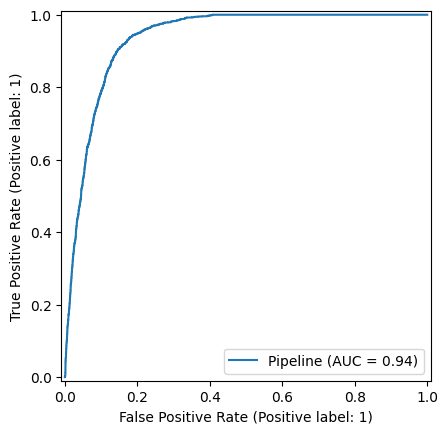

In [38]:
#Creating a pipeline with preprocessor and logistic regression (L2 regularization)
model_l2 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l2', C=1.0, class_weight='balanced', max_iter=1000, random_state=42))
])

#Fit the model
model_l2.fit(X_train, y_train)

#Predict and evaluate
y_pred_l2 = model_l2.predict(X_test)
y_proba_l2 = model_l2.predict_proba(X_test)[:, 1]

#Metrics
print("Classification Report:\n", classification_report(y_test, y_pred_l2))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l2))
roc_score_l2 = roc_auc_score(y_test, y_proba_l2)
print(f"ROC AUC Score: {roc_score_l2:.4f}")

#ROC Curve
RocCurveDisplay.from_estimator(model_l2, X_test, y_test)


**Interpretation**

High recall (1 = arrest): The model is good at identifying most arrests.

Low precision: It's also flagging many false positives (non-arrests as arrests).

Compared to baseline:

- Recall increased from 0.45 to 0.92 

- Precision decreased from 0.61 to 0.42 

- F1-score went up slightly from 0.52 to 0.57 

- ROC AUC stayed similar = 0.9363 → 0.9357

This shows that class_weight='balanced' is doing most of the heavy lifting here. L2 regularization is not drastically affecting performance at this default C=1.0

### d) Logistic Regression Addressing Class Imbalance with Lasso Regularization

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9530 1862]
 [ 114 1332]]
ROC AUC Score: 0.9356


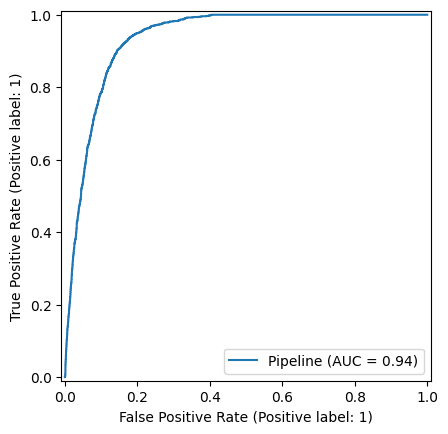

In [39]:
# Logistic Regression with L1 Regularization (Lasso)
model_l1 = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', class_weight='balanced', C=1.0, random_state=42))
])

# Fit the model
model_l1.fit(X_train, y_train)

# Predict
y_pred_l1 = model_l1.predict(X_test)
y_proba_l1 = model_l1.predict_proba(X_test)[:, 1]

# Evaluation
print("Classification Report:\n", classification_report(y_test, y_pred_l1))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_l1))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_l1):.4f}")
RocCurveDisplay.from_estimator(model_l1, X_test, y_test)


| Metric              | L2 (Ridge) | L1 (Lasso) |
| ------------------- | ---------- | ---------- |
| Accuracy            | 0.85       | 0.85       |
| Precision (class 1) | 0.42       | 0.42       |
| Recall (class 1)    | 0.92       | 0.92       |
| F1-score (class 1)  | 0.57       | 0.57       |
| ROC AUC Score       | 0.9357     | 0.9356     |

**Interpretation**:

- Both models heavily favor recall for class 1 (arrests), catching most true positives at the cost of more false positives.

- L1 didn't reduce performance, so it may have removed irrelevant features — that’s a win for model simplicity.

In [40]:
#To obtain features that Lasso zeroed out
#Get names from each transformer
num_features = numeric_features
bin_features = binary_features
ord_features = ordinal_features

#Get feature names from the one-hot encoder
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)

#Combine all transformed feature names in order
all_features = np.concatenate([num_features, bin_features, cat_features, ord_features])


In [41]:
# Get coefficients from trained logistic model
coefficients = model.named_steps['classifier'].coef_[0]

#Pair feature names with coefficients
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

#Add flag for zeroed out features
coef_df['Zeroed_Out'] = coef_df['Coefficient'] == 0.0

#Sort by absolute magnitude of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


In [43]:
zeroed_features = coef_df[coef_df['Zeroed_Out']]
print("Features Zeroed Out by L1 Regularization:")
print(zeroed_features[['Feature', 'Coefficient']])


Features Zeroed Out by L1 Regularization:
Empty DataFrame
Columns: [Feature, Coefficient]
Index: []


**L1 regularization did not zero out any features.**

In [ ]:
#Increase Regularization Strength 
# Stronger regularization: change 'C' (inverse of regularization strength) to 0.1
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(penalty='l1', solver='liblinear', C=0.1, class_weight='balanced'))
])
model.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('bin', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [45]:
# Get coefficients from trained logistic model
coefficients = model.named_steps['classifier'].coef_[0]

#Pair feature names with coefficients
coef_df = pd.DataFrame({
    'Feature': all_features,
    'Coefficient': coefficients
})

#Add flag for zeroed out features
coef_df['Zeroed_Out'] = coef_df['Coefficient'] == 0.0

#Sort by absolute magnitude of coefficients
coef_df['Abs_Coefficient'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coefficient', ascending=False)


In [48]:
zeroed_features = coef_df[coef_df['Zeroed_Out']]
print("Features Zeroed Out by L1 Regularization:")
print(zeroed_features[['Feature', 'Coefficient']])

Features Zeroed Out by L1 Regularization:
                                               Feature  Coefficient
15                        Subject Perceived Race_Other          0.0
13                 Subject Perceived Race_Multi-Racial          0.0
12            Subject Perceived Race_MULTIPLE SUBJECTS          0.0
108                  Initial Call Type_MISSING - CHILD          0.0
107                  Initial Call Type_MISSING - ADULT          0.0
..                                                 ...          ...
420                                           Sector_R          0.0
239  Final Call Type_AUTOMOBILES - LICENSE PLATE(S)...          0.0
418                                         Sector_OOJ          0.0
405                                          Sector_99          0.0
337  Final Call Type_PROPERTY DEST (DAMG) - GRAFFIT...          0.0

[315 rows x 2 columns]


### 2. Simple Model with Tuned Hyperparameters

In [49]:
#GridSearchCV
# Define the logistic regression model
log_reg = LogisticRegression(solver='liblinear', class_weight='balanced', max_iter=1000)

#Set up the parameter grid
param_grid = {
    'classifier__penalty': ['l1', 'l2'],
    'classifier__C': [0.01, 0.1, 1, 10, 100]
}

#Create full pipeline (preprocessor + model)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', log_reg)
])

#Grid search with 5-fold CV
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=2
)

#Fit grid search on training data
grid_search.fit(X_train, y_train)

# Best parameters and ROC AUC
print("Best parameters:", grid_search.best_params_)
print(f"Best cross-validated ROC AUC: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters: {'classifier__C': 1, 'classifier__penalty': 'l2'}
Best cross-validated ROC AUC: 0.9367


Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.84      0.91     11392
           1       0.42      0.92      0.57      1446

    accuracy                           0.85     12838
   macro avg       0.70      0.88      0.74     12838
weighted avg       0.92      0.85      0.87     12838

Confusion Matrix:
 [[9543 1849]
 [ 117 1329]]
ROC AUC Score: 0.9358


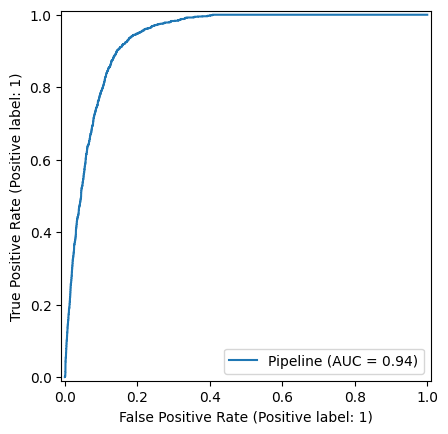

In [50]:
#Evaluating on test set
#Predict with best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba):.4f}")
RocCurveDisplay.from_estimator(best_model, X_test, y_test)


Best Model Summary:

- Best Penalty: 'l2' = Ridge regularization works better than L1 in this case.

- Best C: 1 = This is the default value (moderate regularization).

- ROC AUC (CV): 0.9367 = Slight improvement from the baseline 0.9363.

Tuning confirmed L2 penalty and C=1 as optimal, so the model didn’t change behavior much — which is expected when the default was already working well.

### 3. Decision Tree Classifier


In [ ]:


# Define the model pipeline
tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Fit the model
tree_pipeline.fit(X_train, y_train)

# Predict
y_pred_tree = tree_pipeline.predict(X_test)
y_proba_tree = tree_pipeline.predict_proba(X_test)[:, 1]

# Evaluate
print("Classification Report:\n", classification_report(y_test, y_pred_tree))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_tree))
print(f"ROC AUC Score: {roc_auc_score(y_test, y_proba_tree):.4f}")

# Plot ROC
RocCurveDisplay.from_estimator(tree_pipeline, X_test, y_test)
